In [1]:
import numpy as np 
import pandas as pd
pd.set_option('display.max_rows', 500) 
pd.set_option('display.max_columns', 100) 
# 특별한 데이터 조작을 위한 라이브러리 add on. 
from itertools import product 
from sklearn.preprocessing import LabelEncoder 
# 사용할 시각화 툴 seaborn, pyplot. 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline 
# model은 xgboost을 사용합니다. 
from xgboost import XGBRegressor 
from xgboost import plot_importance
def plot_features(booster, figsize): 
    fig, ax = plt.subplots(1,1,figsize=figsize) 
    return plot_importance(booster=booster, ax=ax) 
# 메모리, 실행시간, 데이터 저장 등, 기타 목적을 위한 라이브러리들. 
import time 
import sys 
import gc 
import pickle 
sys.version_info


sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)

In [2]:
import os
from os.path import join

data_dir = os.getenv('HOME')+'/workplace/hackerton1'

items_data_path = join(data_dir, 'items.csv')
shops_data_path = join(data_dir, 'shops.csv')  
cats_data_path = join(data_dir, 'item_categories.csv')  
train_data_path = join(data_dir, 'sales_train.csv')
test_data_path = join(data_dir, 'test.csv')

items = pd.read_csv(items_data_path) 
shops = pd.read_csv(shops_data_path) 
cats = pd.read_csv(cats_data_path) 
train = pd.read_csv(train_data_path) 
# set index to ID to avoid droping it later 
test = pd.read_csv(test_data_path).set_index('ID')

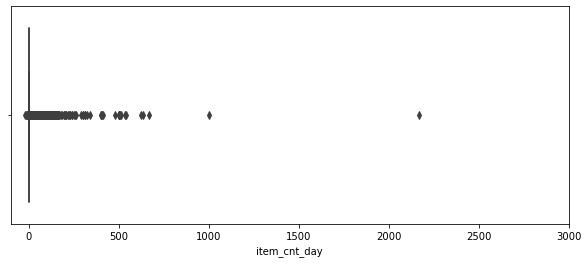

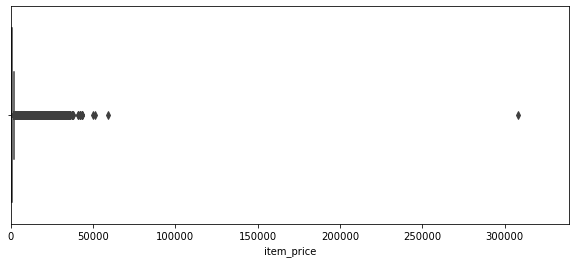

In [3]:
plt.figure(figsize=(10,4)) 
plt.xlim(-100, 3000) 
sns.boxplot(x=train.item_cnt_day) 
plt.figure(figsize=(10,4)) 
plt.xlim(train.item_price.min(), train.item_price.max()*1.1) 
sns.boxplot(x=train.item_price)

In [4]:
train = train[train.item_price<100000] 
train = train[train.item_cnt_day<1001]


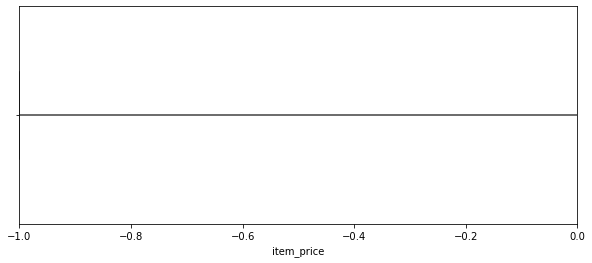

In [5]:
plt.figure(figsize=(10,4)) 
plt.xlim(train.item_price.min(), 0) 
sns.boxplot(x=train.item_price)

In [6]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median() 
train.loc[train.item_price<0, 'item_price'] = median

In [7]:
# Якутск Орджоникидзе, 56 
train.loc[train.shop_id == 0, 'shop_id'] = 57 
test.loc[test.shop_id == 0, 'shop_id'] = 57 
# Якутск ТЦ "Центральный" 
train.loc[train.shop_id == 1, 'shop_id'] = 58 
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м² 
train.loc[train.shop_id == 10, 'shop_id'] = 11 
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [8]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

In [9]:
# shop_name 으로부터 city 를 추출하여 새로운 Feature를 만듭니다. 
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0]) 
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск' 
# Якутск 역시, 통일되지 않은 도시라 보정해줍니다. 
# city 를 LabelEncoder 로 encoding 하여 새로운 Feature를 만듭니다. 
shops['city_code'] = LabelEncoder().fit_transform(shops['city']) 
shops = shops[['shop_id','city_code']]

In [10]:
cats['split'] = cats['item_category_name'].str.split('-') 
cats['type'] = cats['split'].map(lambda x: x[0].strip()) 
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])

In [11]:
# if subtype is nan then type 
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip()) 
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype']) 
cats = cats[['item_category_id','type_code', 'subtype_code']]

In [12]:
items.drop(['item_name'], axis=1, inplace=True)

In [13]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

In [17]:
ts = time.time() 
matrix = [] 
cols = ['date_block_num','shop_id','item_id'] 
for i in range(34): 
    sales = train[train.date_block_num==i] 
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16')) 
matrix = pd.DataFrame(np.vstack(matrix), columns=cols) 
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8) 
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16) 
matrix.sort_values(cols,inplace=True) 
time.time() - ts


6.315720319747925

In [18]:
ts = time.time() 
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']}) 
group.columns = ['item_cnt_month'] 
group.reset_index(inplace=True) 
matrix = pd.merge(matrix, group, on=cols, how='left') 
matrix['item_cnt_month'] = (matrix['item_cnt_month'] .fillna(0) .clip(0,20) 
                            # NB clip target here 
                            .astype(np.float16)) 
time.time() - ts


2.63277530670166

In [19]:
test['date_block_num'] = 34 
test['date_block_num'] = test['date_block_num'].astype(np.int8) 
test['shop_id'] = test['shop_id'].astype(np.int8) 
test['item_id'] = test['item_id'].astype(np.int16)
test.head()


,shop_id,item_id,date_block_num
ID,,,
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [20]:
ts = time.time() 
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols) 
matrix.fillna(0, inplace=True) 
# 34 month 
time.time() - ts

0.0357356071472168

In [21]:
ts = time.time() 
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left') 
matrix = pd.merge(matrix, items, on=['item_id'], how='left') 
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left') 
matrix['city_code'] = matrix['city_code'].astype(np.int8) 
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8) 
matrix['type_code'] = matrix['type_code'].astype(np.int8) 
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8) 
time.time() - ts

2.1133573055267334

In [22]:
def lag_feature(df, lags, col): 
    """ 이전 달의 feature 들을, 현재 월의 feature 로 둡니다. 이 떄, 이전 달들의 정보는 lags 에, 사용할 feature 들은 col 에 담겨져 있습니다. """ 
    tmp = df[['date_block_num','shop_id','item_id',col]] 
    for i in lags: 
        shifted = tmp.copy() 
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)] 
        shifted['date_block_num'] += i 
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left') 
    return df

In [24]:
ts = time.time() 
# 1,2,3,6,12 달 전의 item_cnt_month 값을, 현재 해당 월의 feature 로 둡니다. 
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month') 
time.time() - ts

16.242631196975708

In [25]:
ts = time.time() 
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']}) 
group.columns = [ 'date_avg_item_cnt' ] 
group.reset_index(inplace=True)

In [26]:
matrix = pd.merge(matrix, group, on=['date_block_num'], how='left') 
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16) 
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt') 
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True) 
time.time() - ts


5.853583097457886

In [27]:
ts = time.time() 
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']}) 
group.columns = [ 'date_item_avg_item_cnt' ] 
group.reset_index(inplace=True)

In [28]:
matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left') 
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16) 
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt') 
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True) 
time.time() - ts

19.805257081985474

In [29]:
# 해당 월에, 각각의 상점 단위로, 팔린 상품 갯수의 평균과 레그. (월, 상점) 단위 
ts = time.time() 
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']}) 
group.columns = [ 'date_shop_avg_item_cnt' ] 
group.reset_index(inplace=True) 
matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left') 
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16) 
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True) 
time.time() - ts


20.405516862869263

In [30]:
ts = time.time() 
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']}) 
group.columns = [ 'date_cat_avg_item_cnt' ] 
group.reset_index(inplace=True) 
matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left') 
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt') 
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True) 
time.time() - ts

6.750513553619385

In [31]:
ts = time.time() 
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']}) 
group.columns = ['date_shop_cat_avg_item_cnt'] 
group.reset_index(inplace=True) 
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left') 
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16) 
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt') 
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True) 
time.time() - ts


7.253464460372925

In [32]:
# 해당 월에, 각각의 아이템 타입1 단위로, 팔린 상품 갯수의 평균과 레그. (월, 상점, 타입1) 단위 
ts = time.time() 
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']}) 
group.columns = ['date_shop_type_avg_item_cnt'] 
group.reset_index(inplace=True) 
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left') 
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16) 
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt') 
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True) 
time.time() - ts


7.264817714691162

In [33]:
ts = time.time() 
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']}) 
group.columns = ['date_shop_subtype_avg_item_cnt'] 
group.reset_index(inplace=True) 
matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left') 
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16) 
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt') 
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True) 
time.time() - ts

7.494717597961426

In [34]:
ts = time.time() 
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']}) 
group.columns = [ 'date_city_avg_item_cnt' ] 
group.reset_index(inplace=True) 
matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left') 
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16) 
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt') 
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True) 
time.time() - ts


7.235032558441162

In [35]:
ts = time.time() 
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']}) 
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True) 
matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left') 
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16) 
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt') 
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True) 
time.time() - ts

7.332518577575684

In [36]:
ts = time.time() 
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']}) 
group.columns = [ 'date_subtype_avg_item_cnt' ] 
group.reset_index(inplace=True) 
matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left') 
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16) 
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt') 
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True) 
time.time() - ts

7.342347860336304

In [40]:
ts = time.time() 
# 전 기간동안의 각각 상품의 평균 가격. (상품) 단위. 
group = train.groupby(['item_id']).agg({'item_price': ['mean']}) 
group.columns = ['item_avg_item_price'] 
group.reset_index(inplace=True) 
matrix = pd.merge(matrix, group, on=['item_id'], how='left') 
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)
# 월별 상품 평균 가격. (월, 상품) 단위. 
group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']}) 
group.columns = ['date_item_avg_item_price'] 
group.reset_index(inplace=True) 
matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left') 
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16) 
# 월별, 각 1~6개월 전의 평균 가격 (월, 상품) 단위. 
lags = [1,2,3,4,5,6] 
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price') 
# 월별, 각 1~6개월 전의 평균 가격과 전 기간 평균 가격과의 차이. (월, 상품) 단위. 
# 전 구간 가격 평균하고 1~6달 가격을 비교함으로써, 지난 1~6달간의 가격 트랜드를 알 수 있음. 
for i in lags: 
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price'] 
    # 현재 달 기준, 지난 1~6달 중, 최근의 트랜드를 찾음. 
    # 가장 최근 1달 전이 좋지만, 없을 경우 최대 6달 전까지 찾는 것. 
def select_trend(row): 
    for i in lags: 
        if row['delta_price_lag_'+str(i)]: 
            return row['delta_price_lag_'+str(i)] 
    return 0 
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1) 
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16) 
matrix['delta_price_lag'].fillna(0, inplace=True) 
# feature drop 하기 # 가장 최근 price trend 를 찾았으니, 가격과 관련된 이전 lags 들은 필요 없음. 
fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price'] 
for i in lags: 
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)] 
    fetures_to_drop += ['delta_price_lag_'+str(i)] 
matrix.drop(fetures_to_drop, axis=1, inplace=True) 
time.time() - ts

228.09637355804443

In [41]:
train['revenue'] = train['item_price'] * train['item_cnt_day']

In [42]:
ts = time.time() 
# 월별 각각의 상점 총 매출. (월, 상점) 단위. 
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']}) 
group.columns = ['date_shop_revenue'] 
group.reset_index(inplace=True) 
matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left') 
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)
# 전 기간동안, 각각의 상점 매출 평균. (상점) 단위. 
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']}) 
group.columns = ['shop_avg_revenue'] 
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['shop_id'], how='left') 
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)
# 각각 상점의 월평균 매출 - 전기간 평균매출 의 차이. (월, 상점) 단위.
matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue'] 
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16) 
# 가장 최근 한 달전의 총 매출만 사용. 
matrix = lag_feature(matrix, [1], 'delta_revenue') 
# 최근 총매출 트랜드를 얻었으니, 필요없는 Feature들 다시 삭제. 
matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True) 
time.time() - ts

8.626548051834106

In [43]:
matrix['month'] = matrix['date_block_num'] % 12 
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31]) 
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [44]:
ts = time.time() 
cache = {} 
matrix['item_shop_last_sale'] = -1 
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8) 
# (상점, 상품)단위로, 해당 상품이 해당 월 기준, 몇 달전에 마지막으로 팔렸는지, item_shop_last_sale 에 저장. 
# 예를 들어 1달 전에 팔렸으면 1임. 
for idx, row in matrix.iterrows(): 
    key = str(row.item_id)+' '+str(row.shop_id) 
    if key not in cache: 
        if row.item_cnt_month != 0: 
            cache[key] = row.date_block_num 
    else: 
        last_date_block_num = cache[key] 
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num 
        cache[key] = row.date_block_num 
time.time() - ts

1018.1572840213776

In [47]:
ts = time.time() 
cache = {} 
matrix['item_last_sale'] = -1 
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
# (상품) 단위로, 해당 상품이 해당 월 기준, 몇 달전에 마지막으로 팔렸는지, item_last_sale 에 저장. 
for idx, row in matrix.iterrows(): 
    key = row.item_id 
    if key not in cache: 
        if row.item_cnt_month != 0: 
            cache[key] = row.date_block_num 
    else: 
        last_date_block_num = cache[key] 
        if row.date_block_num > last_date_block_num: 
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num 
            cache[key] = row.date_block_num 
time.time() - ts

649.6204259395599

In [49]:
ts = time.time() 
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min') 
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min') 
time.time() - ts


0.9436912536621094

In [50]:
ts = time.time() 
matrix = matrix[matrix.date_block_num > 11] 
time.time() - ts

0.39582204818725586

In [51]:
ts = time.time() 
def fill_na(df): 
    for col in df.columns: 
        if ('_lag_' in col) & (df[col].isnull().any()): 
            if ('item_cnt' in col): 
                df[col].fillna(0, inplace=True) 
    return df 
matrix = fill_na(matrix) 
time.time() - ts

1.025559902191162

In [52]:
matrix.to_pickle('data.pkl') 
del matrix 
del cache 
del group 
del items 
del shops 
del cats 
del train 
gc.collect();

In [54]:
data = pd.read_pickle('data.pkl')


In [56]:
data = data[[ 
    'date_block_num', 
    'shop_id', 
    'item_id', 
    'item_cnt_month', 
    'city_code', 
    'item_category_id', 
    'type_code', 
    'subtype_code', 
    'item_cnt_month_lag_1', 
    'item_cnt_month_lag_2', 
    'item_cnt_month_lag_3', 
    'item_cnt_month_lag_6', 
    'item_cnt_month_lag_12', 
    'date_avg_item_cnt_lag_1', 
    'date_item_avg_item_cnt_lag_1', 
    'date_item_avg_item_cnt_lag_2', 
    'date_item_avg_item_cnt_lag_3', 
    'date_item_avg_item_cnt_lag_6', 
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1', 
    'date_shop_avg_item_cnt_lag_2', 
    'date_shop_avg_item_cnt_lag_3', 
    'date_shop_avg_item_cnt_lag_6', 
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1', 
             #'date_shop_type_avg_item_cnt_lag_1', 
             #'date_shop_subtype_avg_item_cnt_lag_1', 
    'date_city_avg_item_cnt_lag_1',
    #'date_item_city_avg_item_cnt_lag_1',
             #'date_type_avg_item_cnt_lag_1',
             #'date_subtype_avg_item_cnt_lag_1', 
    'delta_price_lag', 
    'month', 
    'days',
    'item_shop_last_sale',
    'item_last_sale', 
    'item_shop_first_sale', 
    'item_first_sale', ]]

In [57]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month'] 
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1) 
Y_valid = data[data.date_block_num == 33]['item_cnt_month'] 
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)


del data
gc.collect();

ts = time.time() 
model = XGBRegressor( 
    max_depth=8, 
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3, 
    seed=42) 
model.fit( 
    X_train, 
    Y_train,
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True,
    early_stopping_rounds = 10) 
time.time() - ts

[13:58:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.05628	validation_1-rmse:1.04534
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.96628	validation_1-rmse:0.97848
[2]	validation_0-rmse:0.91500	validation_1-rmse:0.94578
[3]	validation_0-rmse:0.88645	validation_1-rmse:0.92973
[4]	validation_0-rmse:0.86726	validation_1-rmse:0.92331
[5]	validation_0-rmse:0.85418	validation_1-rmse:0.92023
[6]	validation_0-rmse:0.84584	validation_1-rmse:0.91643
[7]	validation_0-rmse:0.84001	validation_1-rmse:0.91426
[8]	validation_0-rmse:0.83557	validation_1-rmse:0.91389
[9]	validation_0-rmse:0.83269	validation_1-rmse:0.91345
[10]	

92.27216172218323

In [58]:
Y_pred = model.predict(X_valid).clip(0, 20) 
Y_test = model.predict(X_test).clip(0, 20) 
submission = pd.DataFrame({ 
    "ID": test.index, 
    "item_cnt_month": Y_test 
}) 
submission.to_csv('xgb_submission.csv', index=False) 
# save predictions for an ensemble 
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb')) 
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

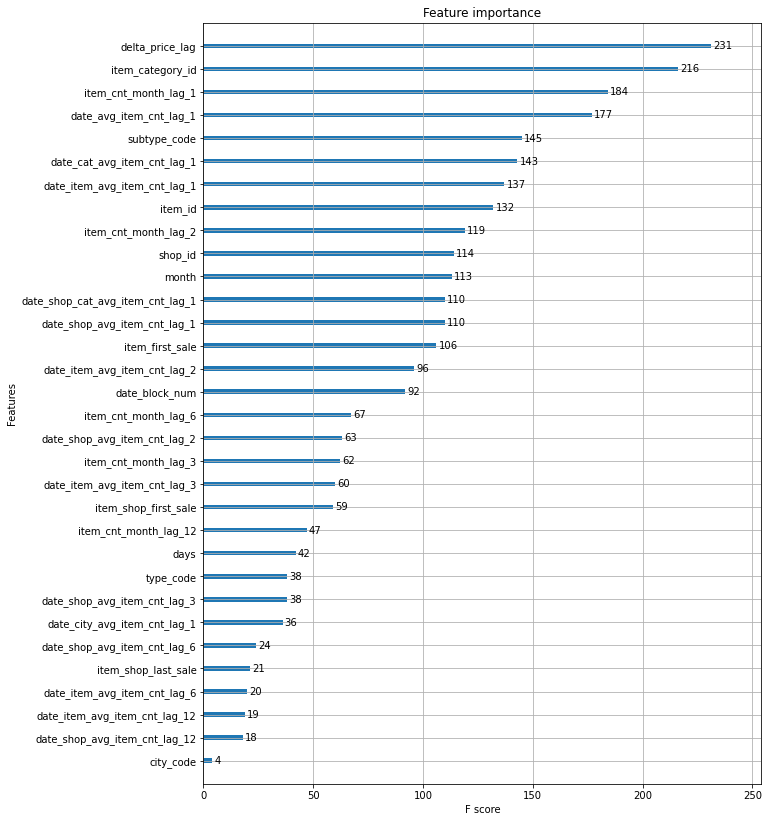

In [59]:
plot_features(model, (10,14))